# Facial Emotion Recognition

#### Table of Contents:

1. [Library Imports](#Library-Imports)
2. [Data Reading & Splitting](#Data-Reading-and-Splitting)
3. [Data Visualization](#Data-Visualization)
4. [Exploratory Data Analysis](#EDA)
5. [Data Augmentation](#Data-Augmentation)
6. [Model Metrics](#Model-Metrics)
7. [Model Training](#Model-Training)
 - [Logistic Regression Baseline](#Logistic-Regression-Baseline)
 - [Simple Neural Network Baseline](#Simple-Neural-Network-Baseline)
 - [Simple Convolutional Neural Network Baseline](#Simple-Convolutional-Neural-Network-Baseline)
 - [Convolutional Neural Network](#Convolutional-Neural-Network-Model)
 - [Transfer Learning](#Transfer-Learning)

### Library Imports

In [1]:
import os
#import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from tensorflow.keras import regularizers as reg
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras import regularizers
from keras.layers import Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout, SpatialDropout2D, BatchNormalization, Resizing, Rescaling, RandomFlip, RandomRotation

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Data Reading and Splitting

In [3]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

# defining dir variables 
root_dir = 'Data/'
train_dir = root_dir + 'train/'
valid_dir = root_dir + 'valid/'
test_dir = root_dir + 'test/'

In [4]:
batch_size = 32
img_height = 180
img_width = 180

train_data = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

valid_data = tf.keras.utils.image_dataset_from_directory(
    valid_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 22962 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.
Found 5747 files belonging to 7 classes.


### Data Visualization

In [5]:
class_names = train_data.class_names
num_classes = len(class_names)
print(class_names)

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


In [6]:
target_var = os.listdir(valid_dir)
target_var

['happy',
 '.DS_Store',
 'sad',
 'fearful',
 'neutral',
 'angry',
 'disgusted',
 'surprised']

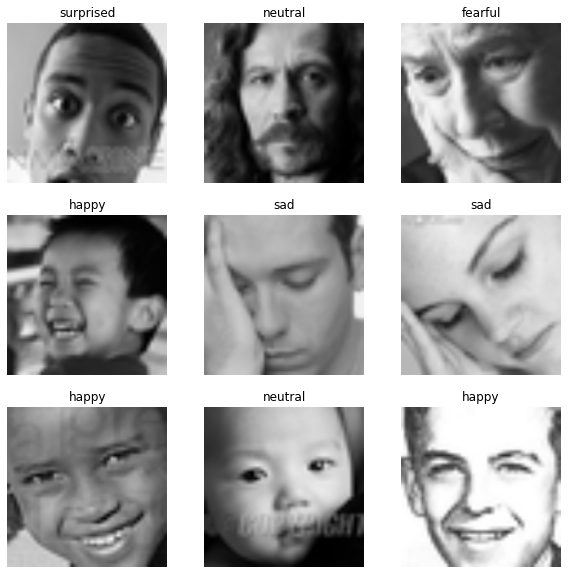

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### EDA

### Data Augmentation

- Resize the images (180x180)
- Scaling/Normalization (1 to 255)
- Randomly flip images (Horizontally)
- Randomly rotate images (up to 20°)

In [8]:
data_augmentation = Sequential([
    Resizing(48, 48),
    Rescaling(1./255),
    RandomFlip("horizontal"),
    RandomRotation(0.2)
])

### Model Metrics

In [9]:
def plot_model_performance(hist, model_name=None, save=False):
    model_hist = pd.DataFrame(hist.history)
    plt.figure(figsize=(8, 5))
    sns.lineplot(data=model_hist[['accuracy', 'val_accuracy']])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Validation'])
    
    if save and model_name:
        plt.title(f'{model_name} Accuracy Graph')
        plt.savefig(f'Images/{model_name} accuracy graph.png', transparent=True, bbox_inches='tight')

### Model Training

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)
valid_data = valid_data.cache().prefetch(buffer_size=AUTOTUNE)

##### Simple Neural Network Baseline

In [11]:
sbase_NN = Sequential()
sbase_NN.add(data_augmentation)
sbase_NN.add(Dense(8, activation='relu'))
sbase_NN.add(Flatten())
sbase_NN.add(Dense(7, activation='softmax'))
sbase_NN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [12]:
sbase_NN_hist = sbase_NN.fit(train_data, epochs=4, validation_data=valid_data, verbose=1)

Epoch 1/4
718/718 [==============================] - 49s 67ms/step - loss: 1.8675 - accuracy: 0.2365 - val_loss: 1.8027 - val_accuracy: 0.2579
Epoch 2/4
718/718 [==============================] - 52s 72ms/step - loss: 1.7959 - accuracy: 0.2609 - val_loss: 1.7899 - val_accuracy: 0.2756
Epoch 3/4
718/718 [==============================] - 42s 59ms/step - loss: 1.7876 - accuracy: 0.2648 - val_loss: 1.7724 - val_accuracy: 0.2765
Epoch 4/4
718/718 [==============================] - 38s 53ms/step - loss: 1.7798 - accuracy: 0.2669 - val_loss: 1.7710 - val_accuracy: 0.2810


FileNotFoundError: [Errno 2] No such file or directory: 'Images/Simple Baseline NN accuracy graph.png'

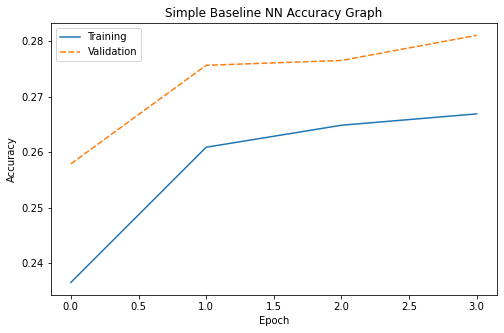

In [13]:
plot_model_performance(sbase_NN_hist,'Simple Baseline NN', save=True)

In [14]:
train_loss, train_acc = sbase_NN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = sbase_NN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', (train_acc - valid_acc) * 100)

180/180 [==============================] - 11s 61ms/step - loss: 1.7710 - accuracy: 0.2810


Training Accuracy:	27.645674347877502
Training Loss:		1.7638105154037476

Validation Accuracy:	28.101617097854614
Validation Loss:	1.7710274457931519

Train/Validation Diff:	 -0.4559427499771118


##### Neural Network Baseline

In [15]:
base_NN = Sequential()
base_NN.add(data_augmentation)
base_NN.add(Dense(4, activation='relu'))
base_NN.add(Dense(8, activation='relu'))
base_NN.add(Dense(16,activation='relu'))
base_NN.add(Dense(32,activation='relu'))
base_NN.add(Dense(16,activation='relu'))
base_NN.add(Dense(8, activation='relu'))
base_NN.add(Flatten())
base_NN.add(Dense(7, activation='softmax'))

base_NN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
base_NN_hist = base_NN.fit(train_data, epochs=6, validation_data=valid_data, verbose=1)

Epoch 1/6
718/718 [==============================] - 90s 123ms/step - loss: 1.7984 - accuracy: 0.2487 - val_loss: 1.7791 - val_accuracy: 0.2584
Epoch 2/6
718/718 [==============================] - 85s 119ms/step - loss: 1.7756 - accuracy: 0.2587 - val_loss: 1.7736 - val_accuracy: 0.2629
Epoch 3/6
718/718 [==============================] - 86s 120ms/step - loss: 1.7673 - accuracy: 0.2654 - val_loss: 1.7545 - val_accuracy: 0.2768
Epoch 4/6
718/718 [==============================] - 89s 123ms/step - loss: 1.7622 - accuracy: 0.2695 - val_loss: 1.7507 - val_accuracy: 0.2775
Epoch 5/6
718/718 [==============================] - 87s 122ms/step - loss: 1.7592 - accuracy: 0.2725 - val_loss: 1.7601 - val_accuracy: 0.2746
Epoch 6/6
718/718 [==============================] - 87s 121ms/step - loss: 1.7577 - accuracy: 0.2768 - val_loss: 1.7536 - val_accuracy: 0.2795


FileNotFoundError: [Errno 2] No such file or directory: 'Images/Baseline NN accuracy graph.png'

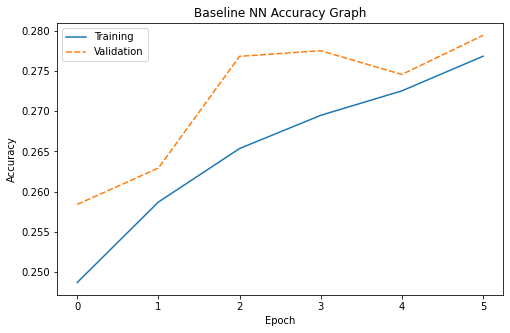

In [17]:
plot_model_performance(base_NN_hist, 'Baseline NN', save=True)

In [18]:
train_loss, train_acc = base_NN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = base_NN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', (train_acc - valid_acc) * 100)

180/180 [==============================] - 13s 71ms/step - loss: 1.7536 - accuracy: 0.2795


Training Accuracy:	28.0550479888916
Training Loss:		1.7470836639404297

Validation Accuracy:	27.94501483440399
Validation Loss:	1.7535642385482788

Train/Validation Diff:	 0.11003315448760986


##### Simple Convolutional Neural Network Baseline

In [19]:
base_CNN = Sequential()
base_CNN.add(data_augmentation)
base_CNN.add(Conv2D(filters=10, kernel_size=3, activation='relu', padding='same'))
base_CNN.add(MaxPooling2D())
base_CNN.add(Conv2D(filters=5, kernel_size=3, activation='relu', padding='same'))
base_CNN.add(MaxPooling2D())
base_CNN.add(Flatten())
base_CNN.add(Dense(7, activation='softmax'))
base_CNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
base_CNN_hist = base_CNN.fit(train_data, epochs=5, validation_data=valid_data, verbose=1)

Epoch 1/5
718/718 [==============================] - 77s 106ms/step - loss: 1.7998 - accuracy: 0.2519 - val_loss: 1.7723 - val_accuracy: 0.2654
Epoch 2/5
718/718 [==============================] - 70s 98ms/step - loss: 1.7704 - accuracy: 0.2637 - val_loss: 1.7605 - val_accuracy: 0.2786
Epoch 3/5
718/718 [==============================] - 68s 94ms/step - loss: 1.7557 - accuracy: 0.2767 - val_loss: 1.7380 - val_accuracy: 0.2908
Epoch 4/5
718/718 [==============================] - 71s 99ms/step - loss: 1.7413 - accuracy: 0.2883 - val_loss: 1.7269 - val_accuracy: 0.2998
Epoch 5/5
718/718 [==============================] - 71s 99ms/step - loss: 1.7293 - accuracy: 0.2971 - val_loss: 1.7250 - val_accuracy: 0.3062


In [ ]:
plot_model_performance(base_CNN_hist, 'Baseline CNN', save=True)

In [21]:
train_loss, train_acc = base_CNN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = base_CNN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', (train_acc - valid_acc) * 100)

180/180 [==============================] - 7s 40ms/step - loss: 1.7250 - accuracy: 0.3062


Training Accuracy:	31.630519032478333
Training Loss:		1.715362310409546

Validation Accuracy:	30.624672770500183
Validation Loss:	1.724967360496521

Train/Validation Diff:	 1.0058462619781494


##### Convolutional Neural Network Model

In [22]:
sgd_opt = SGD(learning_rate=0.001) 
adam_opt = Adam(learning_rate=0.0001)

In [23]:
CNN = Sequential()

CNN.add(data_augmentation)

CNN.add(Conv2D(filters=32, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())
CNN.add(Conv2D(filters=32, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())

CNN.add(Conv2D(filters=64, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())
CNN.add(Conv2D(filters=64, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())

CNN.add(Conv2D(filters=128, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())
CNN.add(Conv2D(filters=128, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())

CNN.add(Conv2D(filters=256, strides=2, kernel_size=3, kernel_regularizer=reg.L2(), activation='relu', padding='same'))
CNN.add(SpatialDropout2D(0.4))
CNN.add(BatchNormalization())

CNN.add(GlobalAveragePooling2D())

CNN.add(Dense(7, activation='softmax'))

CNN.compile(loss='sparse_categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

In [24]:
CNN_hist = CNN.fit(train_data, epochs=300, validation_data=valid_data, verbose=1, callbacks=[keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=.25, patience=4, verbose=1)])

Epoch 1/300
718/718 [==============================] - 93s 126ms/step - loss: 5.7447 - accuracy: 0.1584 - val_loss: 4.7059 - val_accuracy: 0.1989
Epoch 2/300
718/718 [==============================] - 92s 128ms/step - loss: 4.9291 - accuracy: 0.1770 - val_loss: 4.4869 - val_accuracy: 0.2300
Epoch 3/300
718/718 [==============================] - 85s 119ms/step - loss: 4.6506 - accuracy: 0.1875 - val_loss: 4.2868 - val_accuracy: 0.1797
Epoch 4/300
718/718 [==============================] - 88s 122ms/step - loss: 4.4003 - accuracy: 0.1987 - val_loss: 4.1173 - val_accuracy: 0.1770
Epoch 5/300
718/718 [==============================] - 84s 117ms/step - loss: 4.1734 - accuracy: 0.1929 - val_loss: 3.9182 - val_accuracy: 0.2509
Epoch 6/300
718/718 [==============================] - 89s 125ms/step - loss: 3.9629 - accuracy: 0.1986 - val_loss: 3.7447 - val_accuracy: 0.1966
Epoch 7/300
718/718 [==============================] - 90s 125ms/step - loss: 3.7543 - accuracy: 0.2047 - val_loss: 3.5590 -

KeyboardInterrupt: 

In [ ]:
plot_model_performance(CNN_hist, 'Convultional Neural Network', save=True)

In [ ]:
train_loss, train_acc = CNN.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [ ]:
CNN.save('Deliverables/cnn_model.h5')

##### Transfer Learning

Using DenseNet

In [25]:
# Freeze layers
dense_net = DenseNet169(weights='imagenet', include_top=False, input_shape=None)

for layer in dense_net.layers:
    layer.trainable = False

51888128/51877672 [==============================] - 10s 0us/step


In [26]:
CNN_dense_transfer = Sequential()
CNN_dense_transfer.add(dense_net)
CNN_dense_transfer.add(GlobalAveragePooling2D())

CNN_dense_transfer.add(Dense(256 , activation ='relu'))
CNN_dense_transfer.add(BatchNormalization())
CNN_dense_transfer.add(Dense(128 , activation ='relu'))
CNN_dense_transfer.add(BatchNormalization())

CNN_dense_transfer.add(Dense(7, activation='softmax'))

CNN_dense_transfer.compile(loss='sparse_categorical_crossentropy', optimizer=sgd_opt, metrics = ['accuracy'])
CNN_dense_transfer.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, None, None, 1664)  12642880  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               426240    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
dense_13 (Dense)             (None, 7)                

In [27]:
CNN_dense_transfer_hist = CNN_dense_transfer.fit(train_data, epochs=10, validation_data=valid_data, verbose=1)

Epoch 1/10
718/718 [==============================] - 2816s 4s/step - loss: 2.0252 - accuracy: 0.2262 - val_loss: 1.9374 - val_accuracy: 0.2551
Epoch 2/10
176/718 [======>.......................] - ETA: 31:23 - loss: 1.8558 - accuracy: 0.2768

KeyboardInterrupt: 

In [ ]:
plot_model_performance(CNN_dense_transfer_hist, 'Convultional Neural Network with DenseNet Transfer Learning', save=True)

In [ ]:
train_loss, train_acc = CNN_dense_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = CNN_dense_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [ ]:
pickle.dump(CNN_dense_transfer, open('model.pkl', 'wb'))

Using VGG16

In [ ]:
vgg = VGG16(weights='imagenet', include_top=False, input_shape=None)

for layer in vgg.layers:
    layer.trainable = False

In [ ]:
vgg_16_transfer = Sequential()

vgg_16_transfer.add(data_augmentation)

vgg_16_transfer.add(vgg)

vgg_16_transfer.add(GlobalAveragePooling2D()) # try it using max Pooling2

vgg_16_transfer.add(Dense(200 , activation ='relu'))
vgg_16_transfer.add(BatchNormalization())
vgg_16_transfer.add(Dense(200 , activation ='relu'))
vgg_16_transfer.add(BatchNormalization())
vgg_16_transfer.add(Dense(200 , activation ='relu'))

vgg_16_transfer.add(GlobalMaxPooling2D())
vgg_16_transfer.add(Dense(7, activation='softmax'))

vgg_16_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [ ]:
vgg_16_transfer = vgg_16_transfer.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)

In [ ]:
plot_model_performance(vgg_16_transfer, 'Convultional Neural Network with VGG16 Transfer Learning', save=True)

In [ ]:
train_loss, train_acc = vgg_16_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = vgg_16_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [ ]:
pickle.dump(vgg_16_transfer, open('vgg_16_transfer.pkl', 'wb'))

Using VGG19

In [12]:
vgg_19 = VGG19(weights='imagenet', include_top=False, input_shape=None)

for layer in vgg_19.layers[:-2]:
    layer.trainable = False

73703424/80134624 [==========================>...] - ETA: 2s

OSError: [Errno 28] No space left on device

In [2]:
vgg_19_transfer = Sequential()
vgg_19_transfer.add(Dropout(0.2)) # dropout
vgg_19_transfer.add(data_augmentation)

vgg_19_transfer.add(vgg_19)

vgg_19_transfer.add(GlobalAveragePooling2D())

vgg_19_transfer.add(Dense(200 , activation ='relu', kernel_regularizer=regularizers.l2(0.01))) # , kernel_regularizer=regularizers.l2(0.01)
vgg_19_transfer.add(BatchNormalization()) 
vgg_19_transfer.add(Dense(100 , activation ='relu'))

vgg_19_transfer.add(BatchNormalization())
vgg_19_transfer.add(Dense(50 , activation ='relu'))
vgg_19_transfer.add(BatchNormalization())
vgg_19_transfer.add(Dense(7, activation='softmax'))

vgg_19_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

NameError: name 'Sequential' is not defined

In [ ]:
vgg_19_transfer_hist = vgg_19_transfer.fit(train_data, epochs=10, validation_data=valid_data, verbose=1,callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ])

'''
,callbacks=[
        keras.callbacks.EarlyStopping(patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=.5, patience=3, verbose=1),
    ]
'''

In [ ]:
plot_model_performance(vgg_19_transfer_hist, 'Convultional Neural Network with VGG19 Transfer Learning', save=True)

In [ ]:
train_loss, train_acc = vgg_19_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = vgg_19_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [ ]:
pickle.dump(vgg_19_transfer, open('vgg_19_transfer.pkl', 'wb'))

Using InceptionV3

In [ ]:
inception_v3 = InceptionV3(weights='imagenet', include_top=False, input_shape=None)

for layer in inception_v3.layers[:-1]:
    layer.trainable = False

In [ ]:
inception_transfer = Sequential()

vgg_19_transfer.add(Dropout(0.2)) # dropout

inception_transfer.add(data_augmentation)
inception_transfer.add(inception_v3)
inception_transfer.add(GlobalAveragePooling2D())

inception_transfer.add(Dense(200 , activation ='relu'))
inception_transfer.add(BatchNormalization())
inception_transfer.add(Dense(100 , activation ='relu'))
inception_transfer.add(BatchNormalization())
inception_transfer.add(Dense(50 , activation ='relu'))
inception_transfer.add(BatchNormalization())

inception_transfer.add(Dense(7 , activation='softmax'))

inception_transfer.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics = ['accuracy'])

In [ ]:
inception_transfer_hist = inception_transfer.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)

In [ ]:
plot_model_performance(inception_transfer_hist, 'Convultional Neural Network with InceptionV3 Transfer Learning', save=True)

In [ ]:
train_loss, train_acc = inception_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = inception_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [ ]:
pickle.dump(inception_transfer, open('inception_transfer.pkl', 'wb'))

Using ResNet50

In [ ]:
resnet_50 = ResNet50(weights='imagenet', include_top=False, input_shape=None)

for layer in resnet_50.layers[:-1]:
    layer.trainable = False

In [ ]:
resnet_transfer = Sequential()

resnet_transfer.add(data_augmentation)

resnet_transfer.add(resnet_50)

resnet_transfer.add(GlobalAveragePooling2D())

resnet_transfer.add(Dense(200 , activation ='relu'))
resnet_transfer.add(BatchNormalization())
resnet_transfer.add(Dense(100 , activation ='relu'))
resnet_transfer.add(BatchNormalization())
resnet_transfer.add(Dense(100 , activation ='relu'))
resnet_transfer.add(BatchNormalization())

resnet_transfer.add(Dense(7 , activation='softmax'))

resnet_transfer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [ ]:
resnet_transfer_hist = resnet_transfer.fit(train_data, epochs=15, validation_data=valid_data, verbose=1)

In [ ]:
plot_model_performance(resnet_transfer_hist, 'Convultional Neural Network with ResNet50 Transfer Learning', save=True)

In [ ]:
train_loss, train_acc = resnet_transfer.evaluate(train_data, verbose=1)
valid_loss, valid_acc = resnet_transfer.evaluate(valid_data, verbose=1)

print(f'\n\nTraining Accuracy:\t{train_acc * 100}\nTraining Loss:\t\t{train_loss}\n')
print(f'Validation Accuracy:\t{valid_acc * 100}\nValidation Loss:\t{valid_loss}\n')
print('Train/Validation Diff:\t', np.abs(train_acc - valid_acc) * 100)

In [ ]:
pickle.dump(resnet_transfer, open('resnet_transfer.pkl', 'wb'))

##### Chosen Model

From all the models that were testted above, the best model in terms of highest accuracy and least loss and overfit, is the `VGG19` transfer learning model